In [1]:
import os
import warnings
import tqdm
import pandas as pd
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [2]:
%load_ext autoreload
%autoreload 2
import socceraction.atomic.spadl as atomicspadl
import socceraction.atomic.vaep.formula as vaepformula

## Select data

In [3]:
# Configure file and folder names
datafolder = "../data-fifa"
spadl_h5 = os.path.join(datafolder, "atomic-spadl-statsbomb.h5")
predictions_h5 = os.path.join(datafolder, "atomic-predictions-one-action.h5")

In [4]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    players = spadlstore["players"]
    teams = spadlstore["teams"]
print("nb of games:", len(games))

nb of games: 64


## Compute VAEP values

In [5]:
A = []
for game in tqdm.tqdm(list(games.itertuples()), desc="Loading actions"):
    actions = pd.read_hdf(spadl_h5, f"atomic_actions/game_{game.game_id}")
    actions = (
        atomicspadl.add_names(actions)
        .merge(players, how="left")
        .merge(teams, how="left",)
        .sort_values(["game_id", "period_id", "action_id"])
        .reset_index(drop=True)
    )
    preds = pd.read_hdf(predictions_h5, f"game_{game.game_id}")
    values = vaepformula.value(actions, preds.scores, preds.concedes)
    A.append(pd.concat([actions, preds, values], axis=1))
A = pd.concat(A).sort_values(["game_id", "period_id", "time_seconds"]).reset_index(drop=True)
A.columns

Loading actions: 100%|█████████████████████████████████████████████████████████████████| 64/64 [00:03<00:00, 16.96it/s]


Index(['game_id', 'original_event_id', 'action_id', 'period_id',
       'time_seconds', 'team_id', 'player_id', 'x', 'y', 'dx', 'dy', 'type_id',
       'bodypart_id', 'type_name', 'bodypart_name', 'player_name', 'nickname',
       'team_name', 'scores', 'concedes', 'offensive_value', 'defensive_value',
       'vaep_value'],
      dtype='object')

In [6]:
# Use this if you want to assign credit for the receival back to the initial passer
# A["player_id"] = A.player_id.mask(A.type_name == "receival", A.player_id.shift(1))

## Analyse VAEP ratings
### Most valuable players

In [7]:
A["count"] = 1

# Compute each player's number of actions and total VAEP values
playersR = (
    A[["player_id", "vaep_value", "offensive_value", "defensive_value", "count"]]
    .groupby(["player_id"])
    .sum()
    .reset_index()
)
# Add player names
playersR = playersR.merge(players[["player_id", "nickname", "player_name"]], how="left")
playersR["player_name"] = playersR[["nickname", "player_name"]].apply(lambda x: x.iloc[0] if x.iloc[0] else x.iloc[1], axis=1)
# Show results
playersR = playersR[["player_id", "player_name", "vaep_value", "offensive_value", "defensive_value", "count"]]
playersR.sort_values("vaep_value", ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count
6,3009.0,Kylian Mbappé,5.264431,5.121791,0.142640,715
172,5207.0,Cristiano Ronaldo,5.143039,4.748230,0.394809,461
92,3621.0,Eden Hazard,5.035192,4.942459,0.092733,1030
44,3289.0,Romelu Lukaku,4.971518,4.797622,0.173896,393
122,4320.0,Neymar,4.815184,4.761611,0.053573,1115
152,5186.0,Denis Cheryshev,4.423435,5.371259,-0.947823,329
265,5487.0,Antoine Griezmann,4.142828,3.819481,0.323346,801
248,5470.0,Ivan Rakitić,4.129836,3.478681,0.651156,1293
71,3501.0,Philippe Coutinho,4.090387,3.659062,0.431325,1054
209,5246.0,Luis Suárez,4.030627,3.821804,0.208823,514


In [8]:
# Normalize for minutes played
pg = pd.read_hdf(spadl_h5, "player_games")
pg = pg[pg.game_id.isin(games.game_id)]
mp = pg[["player_id", "minutes_played"]].groupby("player_id").sum().reset_index()

stats = playersR.merge(mp)
stats = stats[stats.minutes_played > 180] # at least two full games played
stats["vaep_rating"] = stats.vaep_value * 90 / stats.minutes_played
stats["offensive_rating"] = stats.offensive_value * 90 / stats.minutes_played
stats["defensive_rating"] = stats.defensive_value * 90 / stats.minutes_played
stats.sort_values("vaep_rating", ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
152,5186.0,Denis Cheryshev,4.423435,5.371259,-0.947823,329,317,1.255865,1.524963,-0.269098
117,4269.0,Aleksandar Mitrović,3.741374,3.581401,0.159972,279,276,1.220013,1.167848,0.052165
172,5207.0,Cristiano Ronaldo,5.143039,4.748230,0.394809,461,389,1.189906,1.098562,0.091344
164,5198.0,Diego Costa,3.927535,3.850695,0.076840,270,322,1.097758,1.076281,0.021477
251,5473.0,Ahmed Musa,2.587378,2.057275,0.530103,245,224,1.039572,0.826584,0.212988
34,3237.0,Sergio Agüero,2.727651,2.624050,0.103600,210,243,1.010241,0.971870,0.038371
16,3083.0,Son Heung-Min,3.261400,3.050977,0.210423,342,294,0.998388,0.933973,0.064415
29,3196.0,Wahbi Khazri,2.846517,2.623784,0.222733,285,273,0.938412,0.864984,0.073428
161,5195.0,Artem Dzyuba,3.535283,3.218303,0.316980,419,345,0.922248,0.839557,0.082690
122,4320.0,Neymar,4.815184,4.761611,0.053573,1115,483,0.897239,0.887257,0.009983


### (optional) inspect Belgium's top 10 most valuable non-shot actions

2018-06-23 14:00:00 Belgium 5-2 Tunisia 50' dribble 3621.0


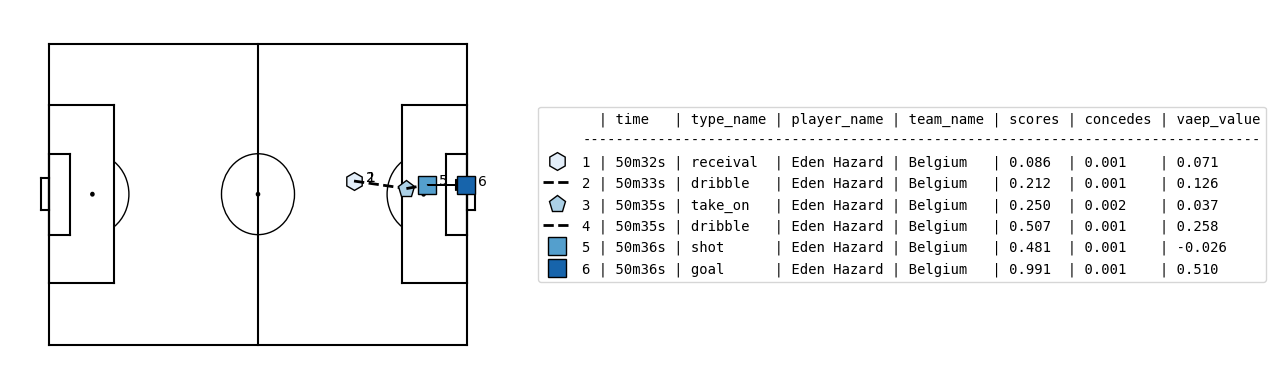

2018-06-23 14:00:00 Belgium 5-2 Tunisia 47' pass 3176.0


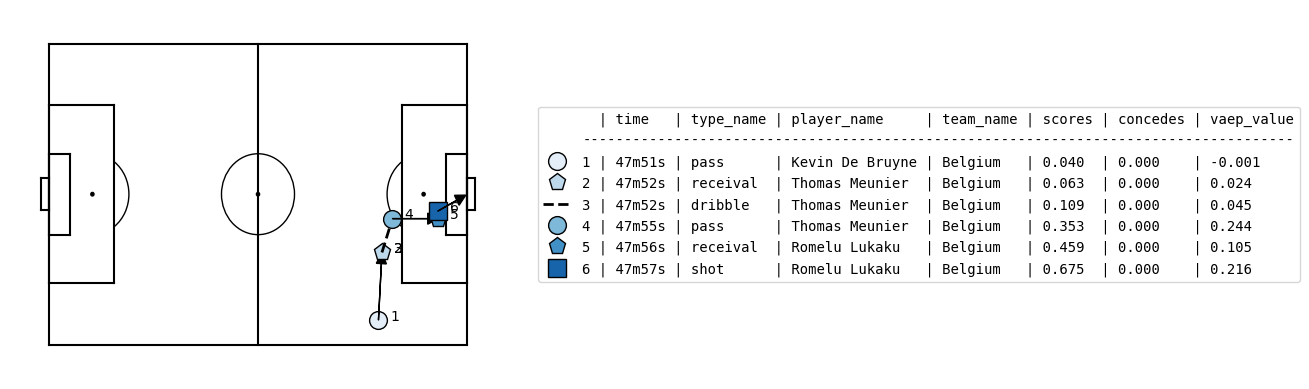

2018-06-18 17:00:00 Belgium 3-0 Panama 74' dribble 3289.0


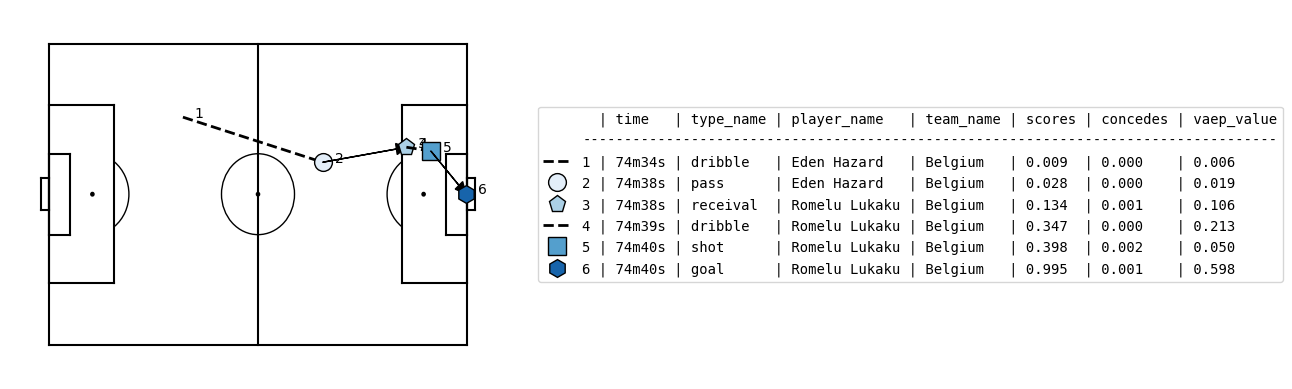

2018-06-23 14:00:00 Belgium 5-2 Tunisia 89' receival 3457.0


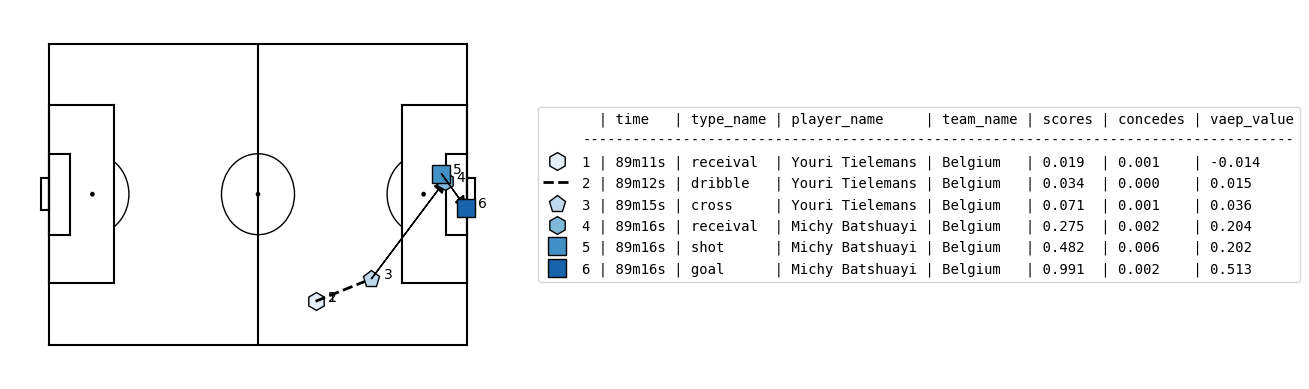

2018-07-14 16:00:00 Belgium 2-0 England 3' receival 3176.0


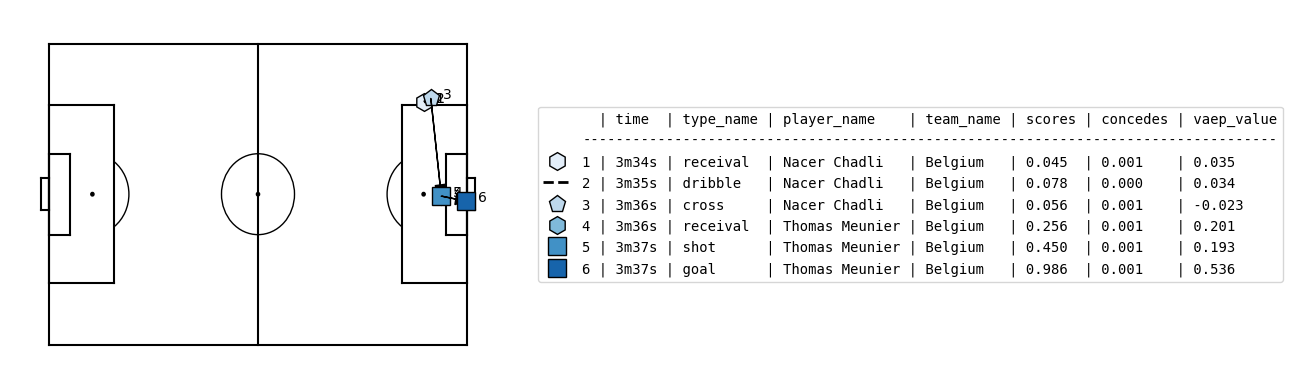

2018-06-23 14:00:00 Belgium 5-2 Tunisia 91' dribble 3457.0


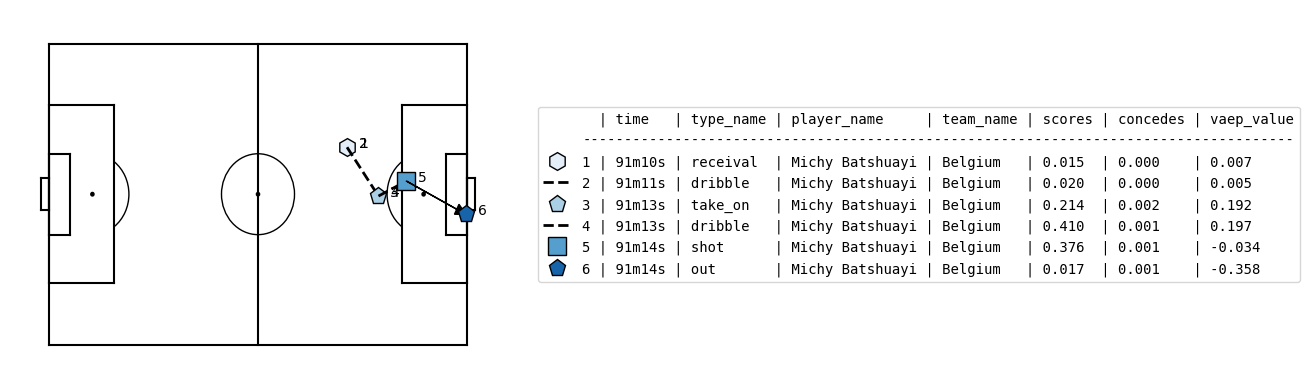

2018-06-23 14:00:00 Belgium 5-2 Tunisia 91' take_on 3457.0


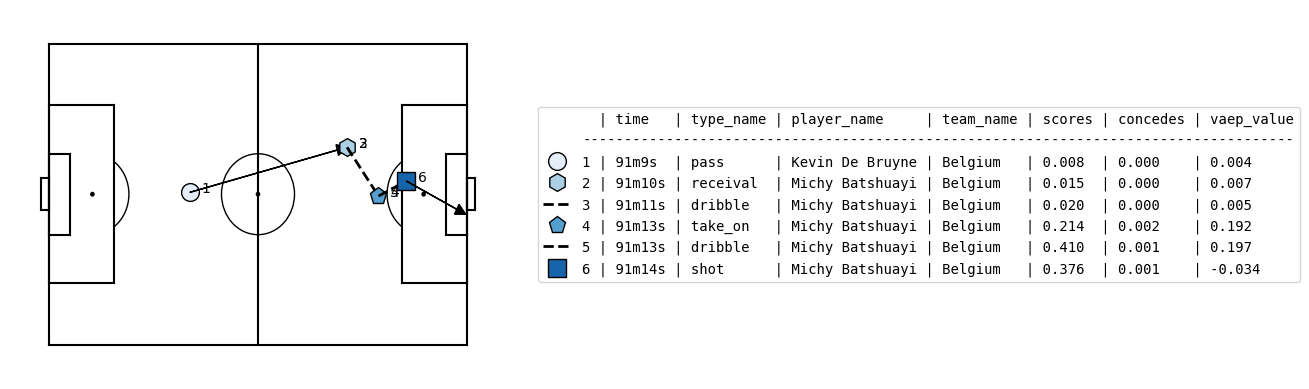

2018-07-02 20:00:00 Belgium 3-2 Japan 73' receival 3296.0


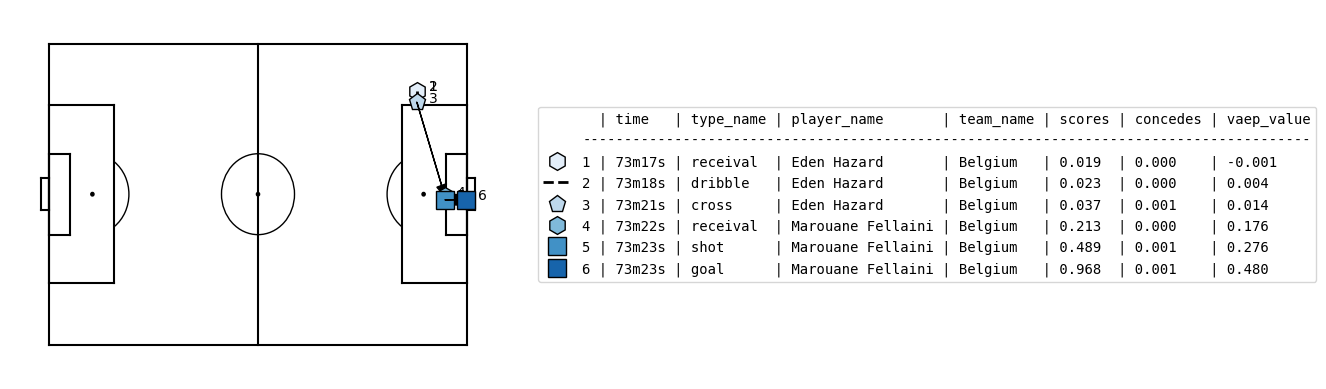

2018-07-02 20:00:00 Belgium 3-2 Japan 93' receival 4831.0


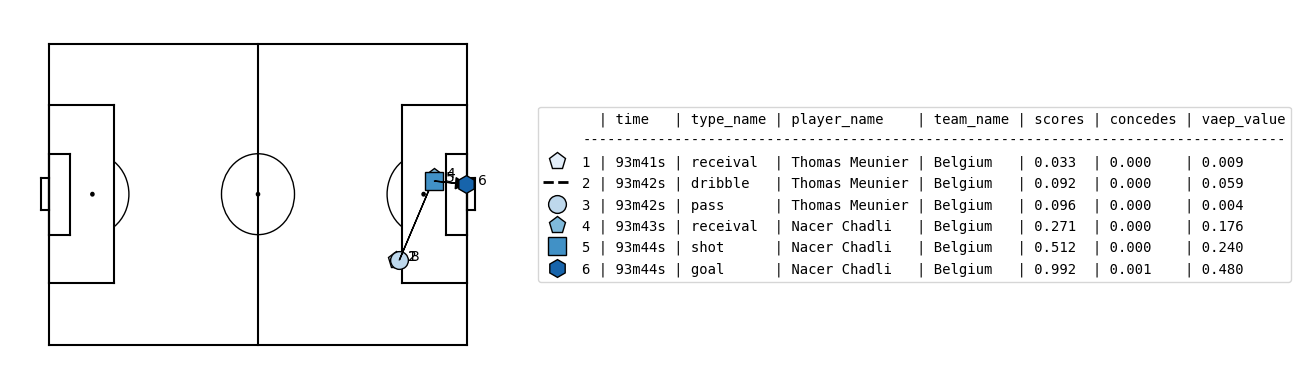

2018-06-28 20:00:00 England 0-1 Belgium 90' receival 3296.0


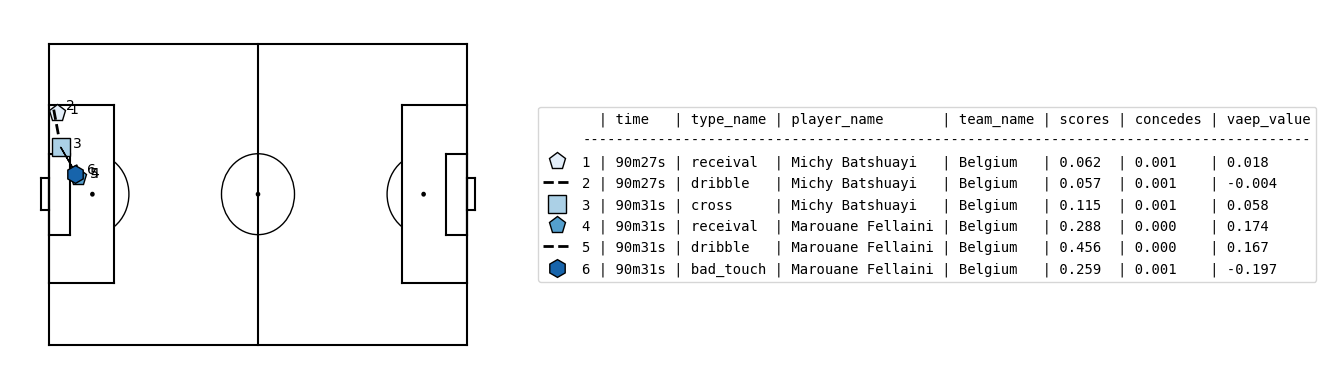

In [9]:
import matplotsoccer

sorted_A = A.sort_values("offensive_value", ascending=False)
sorted_A = sorted_A[sorted_A.team_name == "Belgium"] # view only actions from Belgium
sorted_A = sorted_A[~sorted_A.type_name.isin(["goal", "shot", "shot_penalty"])] #eliminate shots

def get_time(period_id,time_seconds):
    m = int((period_id-1) * 45 + time_seconds // 60)
    s = int(time_seconds % 60)
    return f"{m}m{s}s"

for j in range(0,10):
    row = list(sorted_A[j:j+1].itertuples())[0]
    i = row.Index
    a = A[i - 3 : i + 3].copy()
    
    a["player_name"] = a[["nickname" ,"player_name"]].apply(lambda x: x.iloc[0] if x.iloc[0] else x.iloc[1], axis=1)
    
    g = list(games[games.game_id == a.game_id.values[0]].itertuples())[0]
    game_info = f"{g.game_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name}"
    minute = int((row.period_id - 1) * 45 + row.time_seconds // 60)
    print(f"{game_info} {minute}' {row.type_name} {row.player_id}")

    a["scores"] = a.scores.apply(lambda x : "%.3f" % x )
    a["concedes"] = a.concedes.apply(lambda x : "%.3f" % x )
    a["vaep_value"] = a.vaep_value.apply(lambda x : "%.3f" % x )
    a["time"] = a[["period_id","time_seconds"]].apply(lambda x: get_time(*x),axis=1)
    cols = ["time", "type_name", "player_name", "team_name", "scores", "concedes", "vaep_value"]
    a["end_x"] = a.x + a.dx
    a["end_y"] = a.y + a.dy
    matplotsoccer.actions(a[["x", "y", "end_x", "end_y"]],
                a.type_name,
                team=a.team_name,
                label=a[cols],
                labeltitle = cols,
                zoom=False)